In [1]:
import argparse
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('image', cmap='gray')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
import os
from EyeTracking import EyeTrackingDataset
from Model2 import Net, parse_args
from mpl_toolkits.mplot3d import Axes3D

In [3]:
args_cart = parse_args('--validation-percentage 10 --batch-size 128 --epochs 8 --lr 0.1 --step 1 --gamma 0.7 --reg-lambda 0.001 --seed 1 --log-interval 20'.split())
args_polar = parse_args('--polar --validation-percentage 10 --batch-size 128 --epochs 8 --lr 0.1 --step 1 --gamma 0.7 --reg-lambda 0.001 --seed 1 --log-interval 20'.split())
use_cuda = not args_cart.no_cuda and torch.cuda.is_available()
torch.manual_seed(args_cart.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
path_outputs = '.'
model_cart = Net(args_cart).to(device)
model_polar = Net(args_polar).to(device)

In [4]:
dir_images = r'D:\Data\Unity\Minos\images0'
path_pos = r'D:\Data\Unity\Minos\pos0.bin'
dataset_cart = EyeTrackingDataset(path_pos, dir_images, polar=args_cart.polar, transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(60),
    transforms.ToTensor()
]))
dataset_polar = EyeTrackingDataset(path_pos, dir_images, polar=args_polar.polar, transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(60),
    transforms.ToTensor()
]))
rng = np.random.default_rng(args_cart.seed)
idc = rng.permutation(len(dataset_cart))
n_train = np.round(len(dataset_cart)*(1-args_cart.validation_percentage/100)).astype(int)
val_loader_cart = DataLoader(
    Subset(dataset_cart, idc[n_train:]), batch_size=args_cart.batch_size, **kwargs
)
val_loader_polar = DataLoader(
    Subset(dataset_polar, idc[n_train:]), batch_size=args_polar.batch_size, **kwargs
)

In [5]:
tmpcart = next(iter(val_loader_cart))
tmppolar = next(iter(val_loader_polar))

In [6]:
print(tmppolar[1][:8, :].numpy())
print(dataset_cart.cart2polar(tmpcart[1][:8, :].numpy()))

[[  5.3846164   -7.8289948    5.0769234    0.        ]
 [-30.000002    12.7381935    8.307693     0.        ]
 [-19.230768    -2.1723952    5.769231     0.        ]
 [ 19.230768     9.982629     5.307692     0.        ]
 [-23.846151    16.522028     9.923077     0.        ]
 [ 13.07692     -3.7903244   10.846154     0.        ]
 [ 14.615383    -0.42397413   6.692307     0.        ]
 [ 16.153845     8.111096     7.846154     0.        ]]
[[  5.3846164   -7.8289948    5.0769234    0.        ]
 [-30.000002    12.7381935    8.307693     0.        ]
 [-19.230768    -2.1723952    5.769231     0.        ]
 [ 19.230768     9.982629     5.307692     0.        ]
 [-23.846151    16.522028     9.923077     0.        ]
 [ 13.07692     -3.7903244   10.846154     0.        ]
 [ 14.615383    -0.42397413   6.692307     0.        ]
 [ 16.153845     8.111096     7.846154     0.        ]]


In [7]:
model_cart.load_state_dict(torch.load(os.path.join(path_outputs, 'model2_cart_1.pt')))
model_polar.load_state_dict(torch.load(os.path.join(path_outputs, 'model2_polar_1.pt')))

<All keys matched successfully>

In [8]:
def evaluate(model, data_loader, weight):
    model.eval()    # Set the model to inference mode
    target = None
    output = None
    ref = None
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, gt, rt in data_loader:
            data = data.to(device)
            pred = model.forward(data, weight=weight)
            if target is None:
                target = gt.numpy()
            else:
                target = np.vstack((target, gt.numpy()))
            if ref is None:
                ref = rt.numpy()
            else:
                ref = np.vstack((ref, rt.numpy()))
            if output is None:
                output = pred.cpu().numpy()
            else:
                output = np.vstack((output, pred.cpu().numpy()))
    return output, target, ref

In [9]:
weight_cart = torch.tensor([1., 1., 1., 0.], device=device, pin_memory=True).reshape((1, 4))
weight_polar = torch.tensor([1., 1., 0.5, 0.], device=device, pin_memory=True).reshape((1, 4))

In [11]:
output_cart, target_cart, ref_cart = evaluate(model_cart, val_loader_cart, weight_cart)

In [24]:
output_cart_polar = dataset_cart.cart2polar(output_cart)
target_cart_polar = dataset_cart.cart2polar(target_cart)
error_cart_polar = np.abs(output_cart_polar-target_cart_polar)

In [31]:
output_polar, target_polar, ref_polar = evaluate(model_polar, val_loader_polar, weight_polar)

In [36]:
error_polar = np.abs(output_polar-target_cart_polar)

In [66]:
dist_v = np.linspace(3, 12, 40)
dist = np.linspace(12, 3, 40).reshape((-1, 1)).repeat(1600, axis=1).flatten()
idc_dist = np.linspace(39, 0, 40).astype(np.int).reshape((-1, 1)).repeat(1600, axis=1).flatten()
dist_val = dist[idc[n_train:]]
idc_val = idc_dist[idc[n_train:]]

In [109]:
error_cart_polar_m = np.zeros((40, 4))
error_polar_m = np.zeros((40, 4))
error_cart_polar_std = np.zeros((40, 4))
error_polar_std = np.zeros((40, 4))
for k in range(40):
    error_cart_polar_m[k, :] = error_cart_polar[np.ix_(idc_val==k, np.ones(4, dtype=np.bool))].mean(axis=0)
    error_polar_m[k, :] = error_polar[np.ix_(idc_val==k, np.ones(4, dtype=np.bool))].mean(axis=0)
    error_cart_polar_std[k, :] = error_cart_polar[np.ix_(idc_val==k, np.ones(4, dtype=np.bool))].std(axis=0)/np.sqrt((idc_val==k).sum())
    error_polar_std[k, :] = error_polar[np.ix_(idc_val==k, np.ones(4, dtype=np.bool))].std(axis=0)/np.sqrt((idc_val==k).sum())


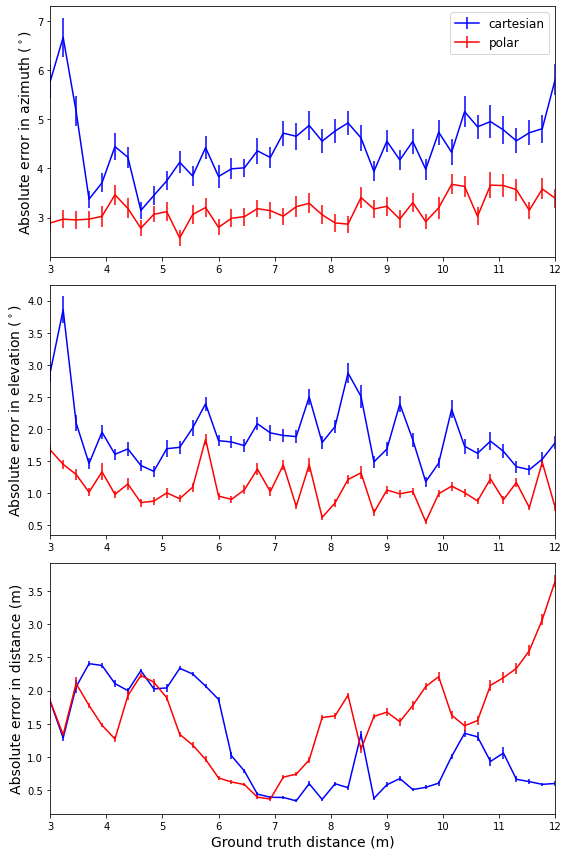

In [116]:
fig = plt.figure(figsize=(8, 12), tight_layout=True)
ylabels = ['Absolute error in azimuth ($^\circ$)', 'Absolute error in elevation ($^\circ$)', 'Absolute error in distance (m)']
for k in range(3):
    plt.subplot(3, 1, k+1)
    plt.errorbar(dist_v, error_cart_polar_m[:, k], fmt='b', yerr=error_cart_polar_std[:, k], label='cartesian')
    plt.errorbar(dist_v, error_polar_m[:, k], fmt='r', yerr=error_polar_std[:, k], label='polar')
    plt.xlim(3, 12)
    plt.ylabel(ylabels[k], fontsize=14)
    if k==0:
        plt.legend(fontsize=12)
    if k==2:
        plt.xlabel('Ground truth distance (m)', fontsize=14)
plt.savefig(os.path.join(path_outputs, 'errors.pdf'), pad_inches=0, bbox_inches='tight')
plt.show()

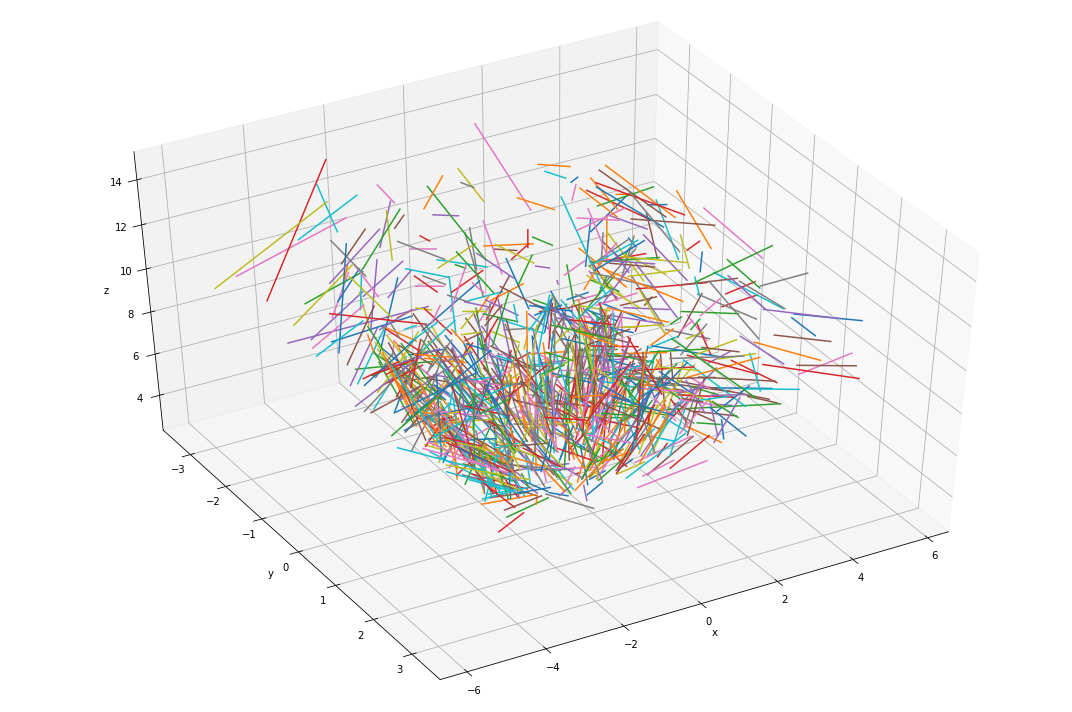

In [121]:
n_sample = 1000

pairs = np.dstack((target_cart[:n_sample, :], output_cart[:n_sample, :]))

fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')

for k in range(n_sample):
    ax.plot(pairs[k, 0, :], pairs[k, 1, :], pairs[k, 2, :])
    
ax.invert_yaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45, 60)

plt.savefig(os.path.join(path_outputs, '3d.png'), pad_inches=0, bbox_inches='tight')
plt.show()

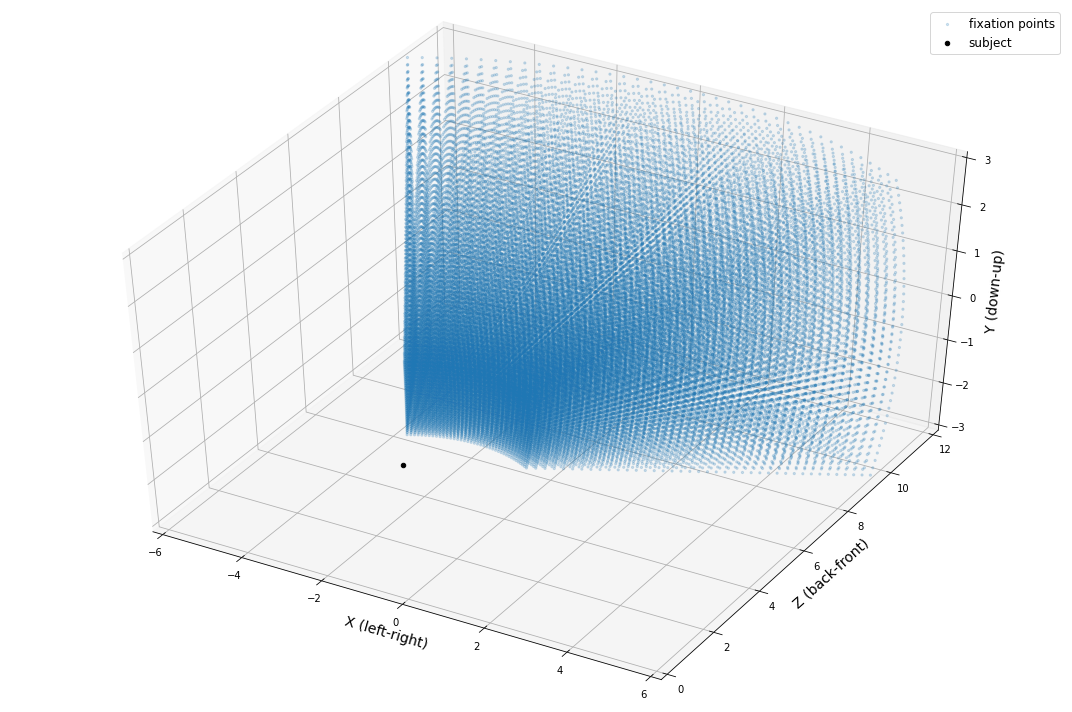

In [141]:
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset_cart.pos[:, 0], dataset_cart.pos[:, 2], dataset_cart.pos[:, 1], s=5, alpha=0.2, label='fixation points')
ax.scatter(0, 0, 0, s=20, c='k', label='subject')
ax.set_xlim(-6, 6)
ax.set_ylim(0, 12)
ax.set_zlim(-3, 3)
ax.set_xlabel('X (left-right)', fontsize=14)
ax.set_ylabel('Z (back-front)', fontsize=14)
ax.set_zlabel('Y (down-up)', fontsize=14)
ax.view_init(45, -60)
ax.legend(fontsize=12)
plt.savefig(os.path.join(path_outputs, '3d_dist.pdf'), pad_inches=0, bbox_inches='tight')
plt.show()

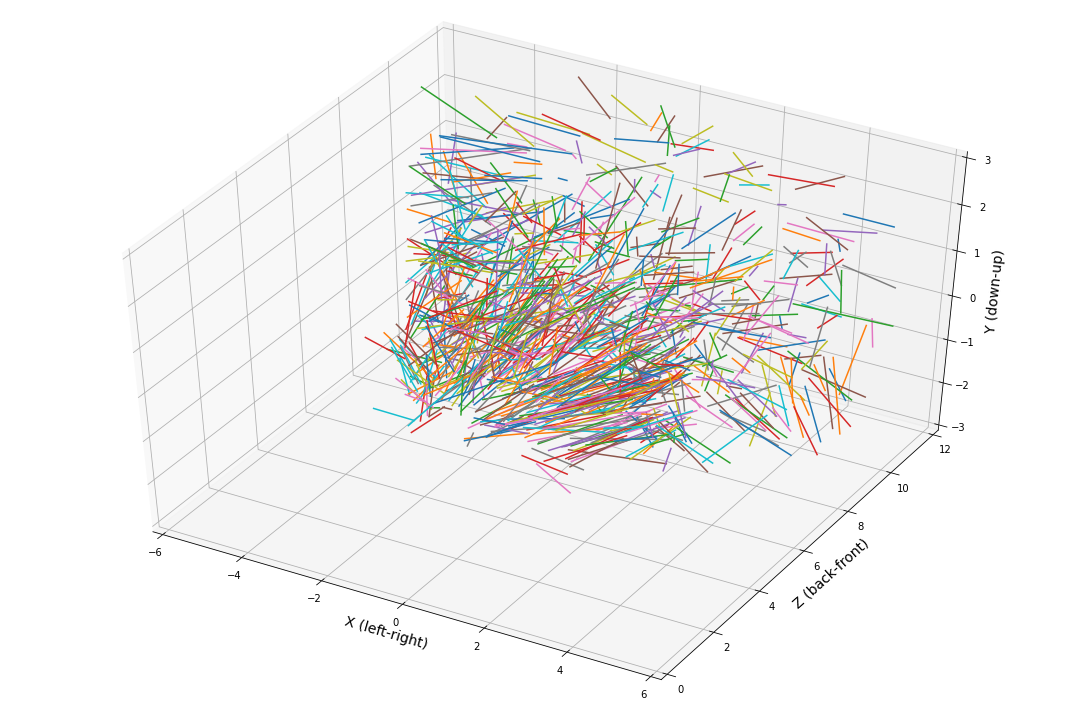

In [144]:
n_sample = 1000
pairs = np.dstack((target_cart[:n_sample, :], output_cart[:n_sample, :]))

fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for k in range(n_sample):
    ax.plot(pairs[k, 0, :], pairs[k, 2, :], pairs[k, 1, :])
ax.set_xlim(-6, 6)
ax.set_ylim(0, 12)
ax.set_zlim(-3, 3)
ax.set_xlabel('X (left-right)', fontsize=14)
ax.set_ylabel('Z (back-front)', fontsize=14)
ax.set_zlabel('Y (down-up)', fontsize=14)
ax.view_init(45, -60)
#ax.legend(fontsize=12)
plt.savefig(os.path.join(path_outputs, '3d_errors.pdf'), pad_inches=0, bbox_inches='tight')
plt.show()

In [ ]:
n_image = len(dataset_cart)
brightness = np.zeros((n_image,))
contrast = np.zeros((n_image,))
for k in range(n_image):
#     if (k+1)%1000==0:
#         print(k+1)
    image = dataset_cart[k][0].numpy().squeeze()
    brightness[k] = image.mean()
    contrast[k] = image.std()


In [ ]:
n_bin = 200
fig = plt.figure(figsize=(15, 6), tight_layout=True)
plt.subplot(121)
plt.hist(brightness, n_bin, density=True)
plt.ylabel('Probability density', fontsize=14)
plt.xlabel('Brightness', fontsize=14)
plt.subplot(122)
plt.hist(contrast, n_bin, density=True)
plt.xlabel('Contrast', fontsize=14)
plt.savefig(os.path.join(path_outputs, 'image_stats.png'), pad_inches=0, bbox_inches='tight')
plt.show()